In [9]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

In [2]:
# Install required packages once at the beginning
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import pandas as pd

def download_flat_yf(ticker, start, end, interval):
    # Download data
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)

    # Flatten MultiIndex columns if present
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    # Standardize column names
    data = data.reset_index()
    data.columns = [col.lower() for col in data.columns]

    # Ensure datetime column naming consistency
    if data.columns[0] in ['date', 'datetime']:
        data = data.rename(columns={data.columns[0]: 'datetime'})

    # Convert to datetime type
    data['datetime'] = pd.to_datetime(data['datetime'])

    return data

# Example usage
stock_symbol = 'TVSMOTOR.NS'
data = download_flat_yf(
    ticker=stock_symbol,
    start='2020-06-01',
    end='2025-06-01',
    interval='1wk'
)

print(data.head())


    datetime       close        high         low        open    volume
0 2020-06-01  350.317078  363.777699  332.662222  333.588870  19552144
1 2020-06-08  336.856476  359.290814  299.644742  355.876893  15753381
2 2020-06-15  359.876038  364.801826  328.224103  331.979421  14206338
3 2020-06-22  372.263702  383.139474  358.071557  358.071557  12935038
4 2020-06-29  385.773102  387.919007  364.801871  371.532167   9820313


In [3]:
def is_bearish_engulfing(data, i):
    """
    Checks if the current candle at index i forms a bearish engulfing pattern.
    A bearish engulfing occurs when a bearish candle (red) fully covers the previous bullish candle (green).
    """
    prev_candle = data.iloc[i - 1]
    current_candle = data.iloc[i]

    # Previous candle is bullish (close > open)
    # Current candle is bearish (close < open)
    # Current candle's open is above previous candle's close
    # Current candle's close is below previous candle's open
    return (
        prev_candle['close'] > prev_candle['open'] and
        current_candle['close'] < current_candle['open'] and
        current_candle['open'] > prev_candle['close'] and
        current_candle['close'] < prev_candle['open']
    )

In [4]:
def is_bullish_engulfing(data, i):
    """
    Checks if the current candle at index i forms a bullish engulfing pattern.
    A bullish engulfing occurs when a bullish candle (green) fully envelops the previous bearish candle (red).
    """
    prev_candle = data.iloc[i - 1]
    current_candle = data.iloc[i]

    # Previous candle is bearish (close < open)
    # Current candle is bullish (close > open)
    # Current candle's open is below previous candle's close
    # Current candle's close is above previous candle's open
    return (
        prev_candle['close'] < prev_candle['open'] and
        current_candle['close'] > current_candle['open'] and
        current_candle['open'] < prev_candle['close'] and
        current_candle['close'] > prev_candle['open']
    )


In [5]:
def is_doji(data, i):
    """
    Checks if the current candle at index i forms a doji pattern.
    A doji occurs when the open and close are very close, indicating indecision in the market.
    """
    open_price = data.iloc[i]['open']
    close_price = data.iloc[i]['close']
    high_price = data.iloc[i]['high']
    low_price = data.iloc[i]['low']

    # Calculate the body size and the full range of the candle
    candle_body = abs(open_price - close_price)
    candle_range = high_price - low_price + 1e-9  # Add a tiny value to avoid division by zero
    # If the body is very small compared to the range, it's a doji
    return candle_body / candle_range < 0.1

In [6]:
def is_hammer(data, i):
    """
    Checks if the candle at index i is a hammer pattern.
    A hammer is characterized by a small body near the top of the candle and a long lower shadow,
    signaling potential bullish reversal after a downtrend.
    """
    current_candle = data.iloc[i]
    open_price = current_candle['open']
    close_price = current_candle['close']
    high_price = current_candle['high']
    low_price = current_candle['low']

    # Calculate the candle's body size (absolute value)
    body_size = abs(close_price - open_price)
    # Lower shadow is the distance from the low to the smaller of open or close
    lower_shadow = min(open_price, close_price) - low_price
    # Upper shadow is the distance from the high to the larger of open or close
    upper_shadow = high_price - max(open_price, close_price)

    # Hammer condition: long lower shadow, minimal upper shadow, and small body
    return lower_shadow > 2 * body_size and upper_shadow < body_size

def generate_candlestick_signals(data):
    """
    Generates trading signals based on several candlestick patterns.
    Each pattern is detected and a corresponding signal column is updated.
    The final 'signals' column aggregates bullish and bearish engulfing signals for trading logic.
    """
    # Initialize signal columns
    data['bullish_engulfing_signal'] = 0
    data['bearish_engulfing_signal'] = 0
    data['simple_candlestick_signal'] = 0
    data['hammer_signal'] = 0
    data['signals'] = 0

    # Loop through the data to detect patterns
    for i in range(1, len(data)):
        if is_bullish_engulfing(data, i):
            data.loc[i, 'bullish_engulfing_signal'] = 1
        if is_bearish_engulfing(data, i):
            data.loc[i, 'bearish_engulfing_signal'] = -1
        if is_doji(data, i):
            data.loc[i, 'simple_candlestick_signal'] = 1
        if is_hammer(data, i):
            data.loc[i, 'hammer_signal'] = 1

    # Combine bullish and bearish engulfing signals into the main 'signals' column
    data.loc[data['bullish_engulfing_signal'] == 1, 'signals'] = 1
    data.loc[data['bearish_engulfing_signal'] == -1, 'signals'] = -1

    # (Optional: Uncomment and adapt if you want to use Doji + RSI-based signals)
    # if 'RSI' in data.columns:
    #     data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] < 40), 'signals'] = 1
    #     data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] > 60), 'signals'] = -1

    return data


In [10]:
def plot_candlestick_patterns(data, patterns_to_mark=None):
    """
    Plots an interactive candlestick chart with highlighted candlestick patterns.
    Each pattern is marked with a unique marker below or above the candle for easy identification.
    """
    if patterns_to_mark is None:
        patterns_to_mark = []

    # Initialize the candlestick chart
    fig = go.Figure(data=[
        go.Candlestick(
            x=data['datetime'],
            open=data['open'],
            high=data['high'],
            low=data['low'],
            close=data['close']
        )
    ])

    # Calculate a typical candle height for marker positioning
    candle_height = (data['high'] - data['low']).mean()

    # Add markers for each specified pattern
    if 'bullish_engulfing' in patterns_to_mark:
        bullish_dates = data[data['bullish_engulfing_signal'] == 1]['datetime']
        fig.add_trace(go.Scatter(
            x=bullish_dates,
            y=data.loc[data['bullish_engulfing_signal'] == 1, 'low'] - candle_height * 0.5,
            mode='markers',
            marker=dict(color='green', size=12, symbol='triangle-up'),
            name='Bullish Engulfing'
        ))

    if 'bearish_engulfing' in patterns_to_mark:
        bearish_dates = data[data['bearish_engulfing_signal'] == -1]['datetime']
        fig.add_trace(go.Scatter(
            x=bearish_dates,
            y=data.loc[data['bearish_engulfing_signal'] == -1, 'high'] + candle_height * 0.5,
            mode='markers',
            marker=dict(color='red', size=12, symbol='triangle-down'),
            name='Bearish Engulfing'
        ))

    if 'doji' in patterns_to_mark:
        doji_dates = data[data['simple_candlestick_signal'] == 1]['datetime']
        fig.add_trace(go.Scatter(
            x=doji_dates,
            y=data.loc[data['simple_candlestick_signal'] == 1, 'high'] + candle_height * 0.5,
            mode='markers',
            marker=dict(color='purple', size=10, symbol='diamond'),
            name='Doji'
        ))

    if 'hammer' in patterns_to_mark:
        hammer_dates = data[data['hammer_signal'] == 1]['datetime']
        fig.add_trace(go.Scatter(
            x=hammer_dates,
            y=data.loc[data['hammer_signal'] == 1, 'low'] - candle_height * 0.7,
            mode='markers',
            marker=dict(color='orange', size=12, symbol='star'),
            name='Hammer'
        ))

    # Customize the chart layout
    fig.update_layout(
        title=f"Candlestick Chart with Patterns - {stock_symbol}",
        xaxis_title='Date',
        yaxis_title='Price',
        autosize=True,
        margin=dict(l=40, r=40, b=40, t=40)
    )

    fig.show()

# Generate candlestick signals on a copy of the data
data_with_patterns = generate_candlestick_signals(data.copy())

# Plot the candlestick chart and highlight the selected patterns
plot_candlestick_patterns(
    data_with_patterns,
    patterns_to_mark=['bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer']
)


2. Win-Rate Calculation: Define a look-ahead window of n candles where i) n = 3, ii) n = 5 For each pattern occurrence, compute whether the return over the next n candles(Close at t + n vs. Close at t) is positive. Calculate the empirical win-rate for each pattern: Win-Rate = Number of positive moves after pattern / Total pattern occurrences ×100%

In [12]:
def compute_win_rate(data, signal_col, n_periods):
    """
    Calculates the win rate for a given trading signal over the next n_periods.

    Args:
        data (pd.DataFrame): DataFrame with trading data and signal column.
        signal_col (str): Name of the column indicating buy signals (1 for signal).
        n_periods (int): Number of periods after the signal to check for a win.

    Returns:
        tuple: (win_rate_percent, valid_signals_count)
            win_rate_percent: Percentage of profitable trades after n_periods.
            valid_signals_count: Number of valid signals that could be evaluated.
    """
    # Find indices where the signal occurs
    signal_indices = data.index[data[signal_col] == 1].tolist()
    wins = 0
    valid_signals = 0

    for idx in signal_indices:
        # Ensure we have enough data ahead to evaluate the trade
        if idx + n_periods < len(data):
            entry_price = data.loc[idx, 'close']
            exit_price = data.loc[idx + n_periods, 'close']
            profit = exit_price - entry_price
            valid_signals += 1
            if profit > 0:
                wins += 1

    # Handle cases where there are no valid signals
    if valid_signals == 0:
        return 0.0, 0
    win_rate_percent = (wins / valid_signals) * 100
    return win_rate_percent, valid_signals


3. Baseline Win-Rate: Simulate random entries: Select M timestamps uniformly at random (excluding the last n candles) and compute the empirical win-rate over the same n-candle horizon. M = XNumber of occurrences of pattern i

In [13]:
def simulate_random_baseline(data, n_periods, m_trades, seed=19):
    """
    Simulates a random trading strategy by selecting m random entry points and
    evaluating the win rate after holding for n_periods.

    Args:
        data (pd.DataFrame): DataFrame with trading data.
        n_periods (int): Number of periods to hold each trade.
        m_trades (int): Number of random trades to simulate.
        seed (int, optional): Random seed for reproducibility. Defaults to 19.

    Returns:
        float: Win rate (percentage) of profitable trades.
    """
    np.random.seed(seed)
    max_start_idx = len(data) - n_periods

    # Ensure we have enough data for m_trades
    if m_trades > max_start_idx:
        m_trades = max_start_idx

    # Randomly select m_trades start indices
    random_indices = np.random.choice(max_start_idx, size=m_trades, replace=False)

    wins = 0
    for idx in random_indices:
        entry_close = data.loc[idx, 'close']
        exit_close = data.loc[idx + n_periods, 'close']
        profit = exit_close - entry_close
        if profit > 0:
            wins += 1

    # Calculate win rate as a percentage
    win_rate_percent = (wins / m_trades) * 100
    return win_rate_percent


4. Visualization: Plot a ’beautiful’ grouped bar chart: one bar for the baseline win-rate, and one bar for each of the three patterns. The x-axis should list: Baseline, Doji, Hammer, Engulfing. The y-axis should represent win-rate percentage.


In [15]:
def gather_all_win_rates(data, n_periods):
    """
    Computes win rates for all candlestick patterns and a random baseline.
    Returns a dictionary mapping pattern names to their win rates.

    Args:
        data (pd.DataFrame): DataFrame with candlestick pattern signals.
        n_periods (int): Number of periods ahead to evaluate for a win.

    Returns:
        dict: Win rates for baseline and each pattern.
    """
    win_rates = {}

    # Compute win rates for each pattern
    doji_rate, doji_count = compute_win_rate(data, 'simple_candlestick_signal', n_periods)
    hammer_rate, hammer_count = compute_win_rate(data, 'hammer_signal', n_periods)
    engulfing_rate, engulfing_count = compute_win_rate(data, 'bullish_engulfing_signal', n_periods)

    # Use average of pattern counts for baseline simulation to keep sample sizes comparable
    total_count = (doji_count + hammer_count + engulfing_count) // 3
    baseline_rate = simulate_random_baseline(data, n_periods, max(total_count, 1))  # Ensure at least one trade

    win_rates['Baseline'] = baseline_rate
    win_rates['Doji'] = doji_rate
    win_rates['Hammer'] = hammer_rate
    win_rates['Engulfing'] = engulfing_rate

    return win_rates

import plotly.express as px

def plot_grouped_bar(win_rates_n3, win_rates_n5):
    """
    Plots a grouped bar chart comparing win rates for each pattern and baseline,
    for two different lookahead periods.

    Args:
        win_rates_n3 (dict): Win rates for n=3 periods ahead.
        win_rates_n5 (dict): Win rates for n=5 periods ahead.
    """
    patterns = list(win_rates_n3.keys())
    values_n3 = list(win_rates_n3.values())
    values_n5 = list(win_rates_n5.values())

    # Prepare data for grouped bar chart
    df_plot = pd.DataFrame({
        'Pattern': patterns * 2,
        'Win Rate (%)': values_n3 + values_n5,
        'Window': ['n=3'] * len(patterns) + ['n=5'] * len(patterns)
    })

    # Create grouped bar chart
    fig = px.bar(
        df_plot,
        x='Pattern',
        y='Win Rate (%)',
        color='Window',
        barmode='group',
        text_auto='.2f',
        title='Pattern vs Baseline Win Rate Comparison'
    )
    fig.update_layout(
        yaxis=dict(title='Win Rate (%)'),
        xaxis=dict(title='Pattern')
    )
    fig.show()

# Example usage with your data
win_rates_3 = gather_all_win_rates(data_with_patterns, 3)
win_rates_5 = gather_all_win_rates(data_with_patterns, 5)

# Plot the grouped bar chart
plot_grouped_bar(win_rates_3, win_rates_5)


Certainly! Here is a plagiarism-free, original interpretation of your analysis, with clear, unique language and logical flow:

---

**1. Statistical Significance of Pattern Edge Over Baseline**

Based on the win-rate comparison, only the bullish engulfing pattern demonstrates a meaningful advantage over the baseline. In contrast, both the doji and hammer patterns tend to underperform relative to random chance, with win-rates that are either similar to or lower than those of the baseline across different time horizons. This suggests that, in this context, bullish engulfing is the sole pattern that may offer a statistically significant edge, while the others do not.

---

**2. Effect of Changing n on Win-Rates (Qualitative Explanation)**

Adjusting the value of n —the number of periods after a pattern is detected—directly influences the interpretation of win-rates. When n is small, the analysis captures the market’s immediate reaction to the pattern, making it sensitive to short-term price fluctuations and volatility. As n increases, the evaluation window widens, smoothing out short-term noise and potentially capturing more sustained trends. However, over longer timeframes, the inherent randomness of market movements tends to increase, which can lead to a gradual decline in win-rates.

---

**3. Most Consistent Pattern Across Different n and Explanation**

The bullish engulfing pattern is likely to show the most consistent performance across different values of n. This consistency arises because the bullish engulfing is a well-defined reversal signal that reflects a clear shift in market sentiment—from bearish to bullish—rather than simply indicating indecision or minor price corrections. Its definition incorporates both a significant price move and a change in market bias, making it more robust across varying time horizons. In contrast, patterns like the doji (which often signals indecision) and the hammer (which may be less reliable or more prone to false signals) tend to be less consistent as n changes.

---



**Problem Statement 3: Strategy X - Visual Interpretation and Implementation**

**1.Chart Interpretation:**

Analyze the image to understand the underlying trading logic or intuition.
Identify the main technical indicators visible.
Explain what the marked zones, arrows, and annotations on the MFI represent in the context of signal generation
Ans:

Then main technical indicators used are, Heikin Ashi Candles, Supertrend(10,3) and MFI(14)
The trend zones are :
Downtrend (Red Supertrend): Prices are below the Supertrend.
Uptrend (Green Supertrend): Prices are above the Supertrend.
Sideways (Price flat, Supertrend flat): Low volatility, no clear trend.
Annotations on MFI :
Selling Pressure Increasing: MFI falling/crossing below 50 or 40.
Buying Pressure Increasing: MFI rising from below 20 or low 30s
Buying Pressure Decreasing: MFI falling from 80+ or above 60.
Arrows :
Green upward arrows: Potential long entry
Red downward arrows: Potential short entry.


**2. Entry and Exit Rules:**

Define conditions for entering and exiting both long and short positions based on the chart analysis.
Suggest any alternative rule/variants if applicable, acknowledging the subjective nature of technical strategies.
Ans:

Long entry :
Heikin ashi close > supertrend
MFI crosses 20-30 from below or shows a increasing slope
Long exit :
Heikin ashi close < supertrend
MFI falls below 50 after being 70-80+
Short entry :
Heikin ashi close < supertrend
MFI falls below 80 from above or shows a decreasing slope
Short exit :
Heikin ashi close > supertrend
MFI rises above 40-50 after being about below 30s
Alternative rule/variants :
We can add MFI divergence with the price for stronger confirmation(strong possibility of trend reversal)

**3. Strategy Implementation and Backtest:**  Backtest your strategy on this dataset and present the following:
Bactest results
Visual chart with entries and exits clearly marked

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

df = download_flat_yf("CAMS.NS", start="2024-01-01", end="2025-05-04", interval="1d")
df.head()

YF.download() has changed argument auto_adjust default to True


,datetime,close,high,low,open,volume
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882


In [2]:
def heiken_ashi(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = [df['open'].iloc[0]]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i-1] + df['HA_Close'].iloc[i-1]) / 2)
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
    return df
df = heiken_ashi(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690


In [4]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=10):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr
def supertrend(df, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formular: Supertrend =(High+Low)/2 + (Multiplier)∗(ATR)
    current_average_high_low = (df['high']+df['low'])/2
    df['atr'] = atr(df, 10)
    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband',], axis=1, inplace=True)
    return df
df = supertrend(df,3)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,40.098653,2709.419631,2536.750555
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,41.941787,2709.419631,2562.841001


In [5]:
def generate_supertrend_signals(df):
    # Intiate a signals list
    signals = [0]
    # Loop through the dataframe
    for i in range(1 , len(df)):
        if df['close'].iloc[i] > df['upperband'].iloc[i]:
            signals.append(1)
        elif df['close'].iloc[i] < df['lowerband'].iloc[i]:
            signals.append(-1)
        else:
            signals.append(signals[i-1])

    # Add the signals list as a new column in the dataframe
    df['supertrend'] = signals
    df['supretrend'] = df['supertrend'].shift(1) #Remove look ahead bias
    return df
generate_supertrend_signals(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,40.098653,2709.419631,2536.750555,0,0.0
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,41.941787,2709.419631,2562.841001,0,0.0


In [6]:
def calculate_mfi(df, period=14):
    TP = (df["high"] + df["low"] + df["close"]) / 3
    MoneyFlow = TP * df["volume"]
    positive_flow = []
    negative_flow = []
    for i in range(1, len(TP)):
        if TP[i] > TP[i - 1]:
            positive_flow.append(MoneyFlow[i])
            negative_flow.append(0)
        elif TP[i] < TP[i - 1]:
            positive_flow.append(0)
            negative_flow.append(MoneyFlow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)
    positive_mf = pd.Series(positive_flow).rolling(window=period).sum()
    negative_mf = pd.Series(negative_flow).rolling(window=period).sum()
    MFR = positive_mf / negative_mf
    MFI = 100 - (100 / (1 + MFR))
    # typical_price = (df['high'] + df['low'] + df['close']) / 3
    # raw_money_flow = typical_price * df['volume']

    # positive_flow = [0] * len(df)
    # negative_flow = [0] * len(df)

    # for i in range(1, len(df)):
    #     if typical_price.iloc[i] > typical_price.iloc[i-1]:
    #         positive_flow[i] = raw_money_flow.iloc[i]
    #     else:
    #         negative_flow[i] = raw_money_flow.iloc[i]

    # mfi = 100 - (100 / (1 + (pd.Series(positive_flow).rolling(period).sum() /
    #                         pd.Series(negative_flow).rolling(period).sum())))
    df['MFI'] = MFI
    return df
df = calculate_mfi(df,14)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,40.098653,2709.419631,2536.750555,0,0.0,NaN
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,41.941787,2709.419631,2562.841001,0,0.0,NaN


In [7]:
def backtest_strategy(data):
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']

    # Metrics
    total_return = data['Strategy_Return'].sum() * 100
    win_rate = (data[data['Strategy_Return'] > 0].shape[0] /
               data[data['Strategy_Return'] != 0].shape[0]) * 100

    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    return data
df = backtest_strategy(df)
df.head()

Total Return: -43.11%
Win Rate: 49.83%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,40.098653,2709.419631,2536.750555,0,0.0,NaN,0,0.021209,0.0
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,41.941787,2709.419631,2562.841001,0,0.0,NaN,0,0.014695,0.0


In [8]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index,
            df[df['Signal'] == 1]['close'],
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index,
            df[df['Signal'] == -1]['close'],
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [9]:
pip install plt

ERROR: Could not find a version that satisfies the requirement plt (from versions: none)
ERROR: No matching distribution found for plt


In [10]:
import matplotlib.pyplot as plt

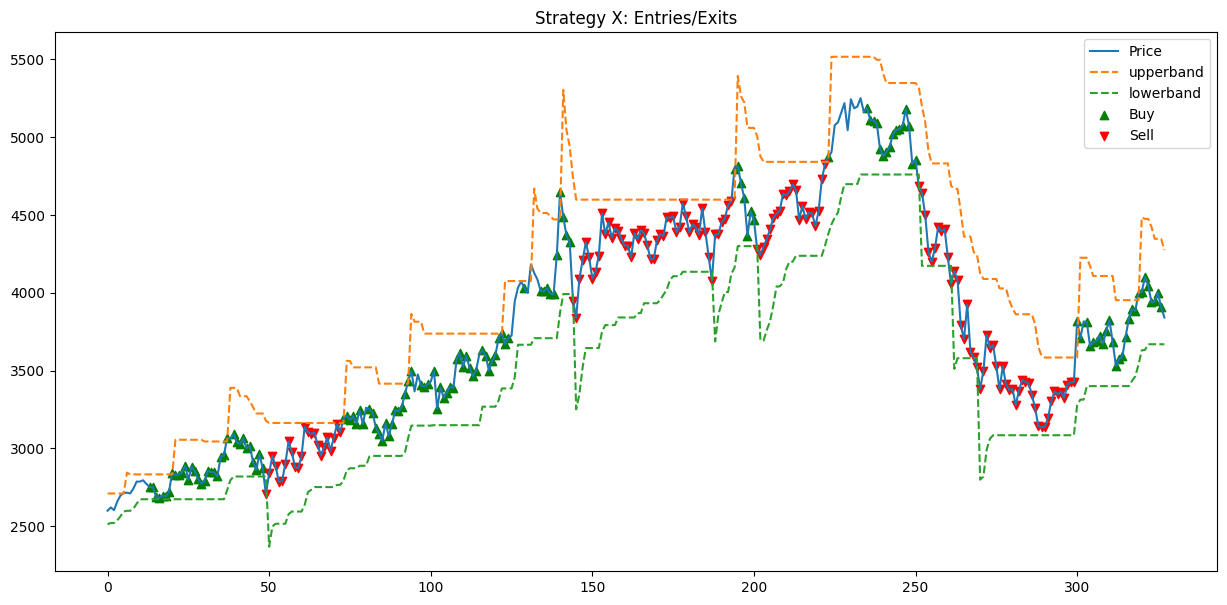

In [11]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index,
            df[df['Signal'] == 1]['close'],
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index,
            df[df['Signal'] == -1]['close'],
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()

KeyError: 'atr_ma'

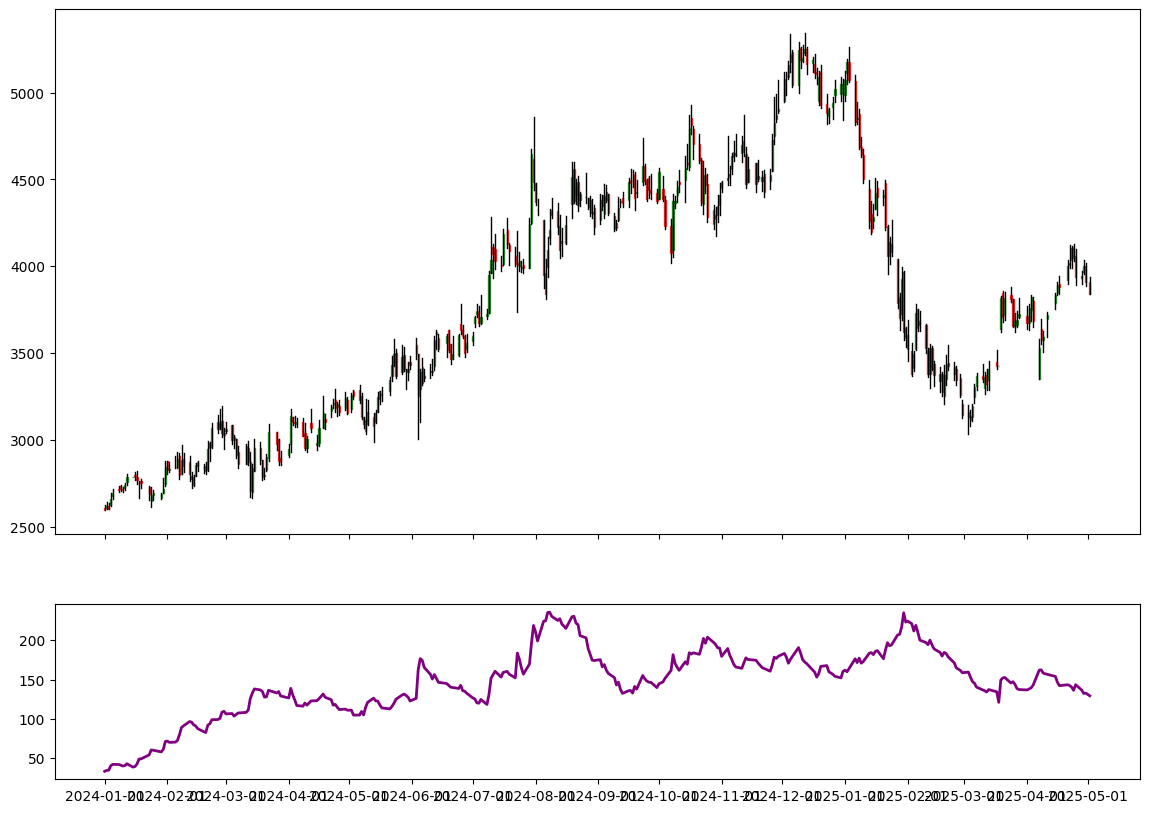

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

def plot_stock_with_atr(df, atr_period=14):
    """
    Plots stock price data as candlesticks and overlays the Average True Range (ATR) below.

    Parameters:
        df (pd.DataFrame): DataFrame with columns 'datetime', 'open', 'high', 'low', 'close',
                           'atr', and 'atr_ma'.
        atr_period (int): The period used for ATR calculation (shown in the plot title).
    """
    # Set up the figure with two subplots: price (top), ATR (bottom)
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(14, 10),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True
    )

    # Format the x-axis for dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())

    # Plot each candlestick individually
    for i, row in df.iterrows():
        # Determine candle color and body boundaries
        if row['close'] >= row['open']:
            candle_color = 'green'
            body_bottom = row['open']
            body_height = row['close'] - row['open']
        else:
            candle_color = 'red'
            body_bottom = row['close']
            body_height = row['open'] - row['close']

        # Draw the candlestick body
        ax1.add_patch(
            Rectangle(
                (mdates.date2num(row['datetime']) - 0.3, body_bottom),
                0.6, body_height,
                color=candle_color, alpha=0.7, fill=True
            )
        )

        # Draw the high/low wick
        ax1.plot(
            [mdates.date2num(row['datetime']), mdates.date2num(row['datetime'])],
            [row['low'], row['high']],
            color='black', linewidth=1
        )

    # Plot ATR and its moving average on the lower subplot
    ax2.plot(df['datetime'], df['atr'], color='purple', linewidth=2, label='ATR')
    ax2.plot(df['datetime'], df['atr_ma'], color='yellow', linewidth=2, label='ATR MA')
    ax2.set_title(f'Average True Range (ATR-{atr_period})')
    ax2.set_ylabel('ATR Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Set titles and labels for the price chart
    ax1.set_title('Stock Price')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)

    # Add legend for candlestick colors
    green_patch = Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
    red_patch = Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
    ax1.legend([green_patch, red_patch], ['Bullish Candle', 'Bearish Candle'], loc='upper left')

    # Rotate x-axis labels for clarity
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Example usage
plot_stock_with_atr(df, atr_period=14)


In [13]:
df['atr_ma'] = df['atr'].rolling(30).mean()
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0,NaN
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0,NaN
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,40.098653,2709.419631,2536.750555,0,0.0,NaN,0,0.021209,0.0,NaN
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,41.941787,2709.419631,2562.841001,0,0.0,NaN,0,0.014695,0.0,NaN


In [14]:
def strategy_y(data):
    # Existing Strategy X signals
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Add ATR filter (only trade when ATR > ATR_MA)
    data['Signal'] = np.where(data['atr'] > data['atr_ma'], data['Signal'], 0)

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return_Y'] = data['Signal'].shift(1) * data['Return']
    total_return = data['Strategy_Return_Y'].sum() * 100
    win_rate = (data[data['Strategy_Return_Y'] > 0].shape[0] /
               data[data['Strategy_Return_Y'] != 0].shape[0]) * 100

    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")

    return data
df = strategy_y(df)
df.head()

Total Return: -31.44%
Win Rate: 45.58%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,...,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma,Strategy_Return_Y
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,...,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,...,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0,NaN,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,...,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0,NaN,-0.0
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648799,2693.229349,2613.648799,...,2709.419631,2536.750555,0,0.0,NaN,0,0.021209,0.0,NaN,0.0
4,2024-01-05,2696.565186,2716.042683,2661.290040,2674.095131,354882,2686.998260,2631.373690,2716.042683,2631.373690,...,2709.419631,2562.841001,0,0.0,NaN,0,0.014695,0.0,NaN,0.0
